In [1]:
import os
import sys
import gc
# assuming data, models, engine in flicc directory:
flicc_path = os.path.realpath("__file__").split('grid_search')[0]
sys.path.append(flicc_path)
import torch
from data import ClimateDataset
from models import ClassificationModel
from engine import Engine

In [2]:
model_checkpoint='microsoft/deberta-base'

In [3]:
results = {'test_acc':[],
           'test_f1':[],
           'eval_acc':[],
           'eval_f1':[],
           'rank, alpha':[]}

In [4]:
lr = 1.0e-5
wd = 0.0
alphas = [8, 16]
ranks = [8, 16]
lora_dropout = 0.0


for a,r in zip(alphas, ranks):
    print(f'Grid search {model_checkpoint}, learning rate {lr} wd: {wd}, Lora alpha {a}, rank {r}')
    data = ClimateDataset(model_to_train=2,model_checkpoint=model_checkpoint,dataset_url=flicc_path,batch_size=32)
    data.setup_dataloaders()
    model = ClassificationModel(model_checkpoint=data.model_checkpoint,
                            num_labels=data.num_labels,
                            lora=True,
                            r=r,
                            alpha=a,
                            dropout=lora_dropout)
    trainer = Engine(epochs=30,labels=data.labels)
    trainer.model = model.model
    trainer.dataset_encoded = data.dataset_encoded
    test_acc, test_f1, eval_acc, eval_f1 = trainer.run(lr=lr,
                          wd=wd,
                          train_dataloader=data.train_dataloader,
                          eval_dataloader=data.eval_dataloader,
                          test_dataloader=data.test_dataloader,
                          early_stop=3)
    results['test_acc'].append(test_acc)
    results['test_f1'].append(test_f1)
    results['eval_acc'].append(eval_acc)
    results['eval_f1'].append(eval_f1)
    results['rank, alpha'].append(r)
    print('### '*10)
    print(results)
    print('### '*10)
    with torch.no_grad():
        torch.cuda.empty_cache()
    del data, model, trainer, test_acc, test_f1, eval_acc, eval_f1
    gc.collect()

Grid search microsoft/deberta-base, learning rate 1e-05 wd: 0.0, Lora alpha 8, rank 8


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'pooler.dense.weight', 'pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	1.0997	Val Loss:	1.1015	Accuracy:	0.3025	F1:	0.1548
2 / 30: Train Loss:	1.1019	Val Loss:	1.1009	Accuracy:	0.3025	F1:	0.1548
3 / 30: Train Loss:	1.1026	Val Loss:	1.1004	Accuracy:	0.3025	F1:	0.1548
4 / 30: Train Loss:	1.1031	Val Loss:	1.1000	Accuracy:	0.3866	F1:	0.2021
5 / 30: Train Loss:	1.1017	Val Loss:	1.0995	Accuracy:	0.3782	F1:	0.1829
6 / 30: Train Loss:	1.1025	Val Loss:	1.0992	Accuracy:	0.3782	F1:	0.1829
7 / 30: Train Loss:	1.0990	Val Loss:	1.0988	Accuracy:	0.3782	F1:	0.1829
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
                    precision    recall  f1-score   support

 misrepresentation       0.00      0.00      0.00        38
oversimplification       1.00      0.03      0.05        36
slothful induction       0.38      1.00      0.55        45

          accuracy                           0.39       119
         macro avg       0.46      0.34      0.20       119
      weighted avg       0.45      0.39      0

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'pooler.dense.weight', 'pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	1.0997	Val Loss:	1.1015	Accuracy:	0.3025	F1:	0.1548
2 / 30: Train Loss:	1.1019	Val Loss:	1.1009	Accuracy:	0.3025	F1:	0.1548
3 / 30: Train Loss:	1.1026	Val Loss:	1.1004	Accuracy:	0.3025	F1:	0.1548
4 / 30: Train Loss:	1.1031	Val Loss:	1.0999	Accuracy:	0.3866	F1:	0.2021
5 / 30: Train Loss:	1.1017	Val Loss:	1.0995	Accuracy:	0.3782	F1:	0.1829
6 / 30: Train Loss:	1.1024	Val Loss:	1.0991	Accuracy:	0.3782	F1:	0.1829
7 / 30: Train Loss:	1.0989	Val Loss:	1.0988	Accuracy:	0.3782	F1:	0.1829
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
                    precision    recall  f1-score   support

 misrepresentation       0.00      0.00      0.00        38
oversimplification       1.00      0.03      0.05        36
slothful induction       0.38      1.00      0.55        45

          accuracy                           0.39       119
         macro avg       0.46      0.34      0.20       119
      weighted avg       0.45      0.39      0

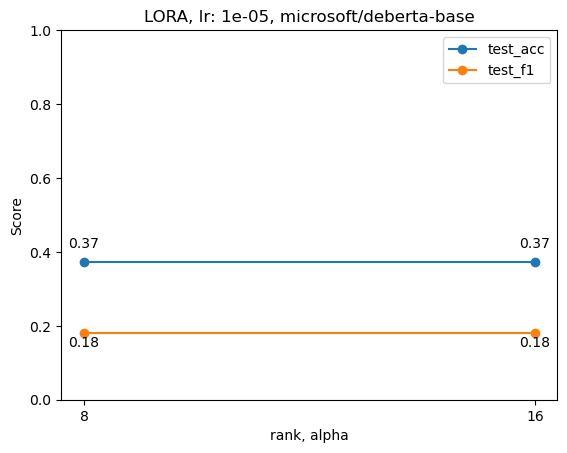

In [5]:
Engine.plot_grid_search(df=results,
                        title=f'LORA, lr: {lr}, {model_checkpoint}',
                        column='rank, alpha',
                        sci_format=False)

In [6]:
%reset -f